# Plot FigS5: Cross-slope sections

In [1]:
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code')
import os
from netCDF4 import *
from numpy import *
import copy
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from fxn_rotate_vector_cice import rotate_vector_cice
from fxn_rotate_vector_roms import rotate_vector_roms
from fxn_cartesian_grid_3d import *
import xarray as xr
import subprocess
import gsw
import cmocean.cm as cm

### Load data (time mean)

In [2]:
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
# path_to_data = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/POST_PROCESS/'

Load ROMS grid info

In [3]:
# Degrees to radians conversion
deg2rad = pi/180.0

roms_grid = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/metroms_CONTROL/ocean_his_0042.nc'
# Read grid, zice, bathymetry
id   = Dataset(roms_grid, 'r')
lon_2d  = id.variables['lon_rho'][:-15,:-1]
lat_2d  = id.variables['lat_rho'][:-15,:-1]
zice = id.variables['zice'][:-15,:-1]
h    = id.variables['h'][:-15,:-1]
temp = id.variables['temp'][0,0,:-15,:-1]
angle = id.variables['angle'][:-15,:-1]
id.close()

# ROMS vertical grid parameters
theta_s = 7.0
theta_b = 2.0
hc = 250
N = 31

# Get integrands on 3D grid
dx, dy, dz, z_3d = cartesian_grid_3d(lon_2d, lat_2d, h, zice, theta_s, theta_b, hc, N)

In [4]:
# Mask
h    = ma.masked_where(ma.getmask(temp), h)
# Make ice shelves deep so they appear black
zice_ma = ma.masked_where(ma.getmask(temp), zice)
h[zice_ma<0] = 6000

# Convert to spherical coordinates
x    = -(lat_2d+90)*cos(lon_2d*deg2rad+pi/2)
y    = (lat_2d+90)*sin(lon_2d*deg2rad+pi/2)

Load CICE grid info

In [5]:
# Grid info from raw cice file
dim_cice = xr.open_dataset(path + 'RAW/metroms_CONTROL/cice/history/' + 'iceh.2010-01-05.nc')

lon2d_cice = dim_cice.TLON
lat2d_cice = dim_cice.TLAT

Temperature

In [6]:
# temp_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_temp_3d_CONTROL_2008_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
temp_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_temp_3d_CONTROL_2008_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
temp_cntr = temp_cntr.temp[:,:-15,:-1]

temp_pert = xr.open_dataset(path + 'POST_PROCESS/ocean_temp_3d_2SSFLUX_2008_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
temp_pert = temp_pert.temp[:,:-15,:-1]

Salinity

In [7]:
salt_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_salt_3d_CONTROL_2008_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
salt_cntr = salt_cntr.salt[:,:-15,:-1]

salt_pert = xr.open_dataset(path + 'POST_PROCESS/ocean_salt_3d_2SSFLUX_2008_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
salt_pert = salt_pert.salt[:,:-15,:-1]

Velocity (sea ice)

In [8]:
# Sea ice velocity
vel_cntr = xr.open_dataset(path + 'POST_PROCESS/uvel_vvel_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
vel_pert = xr.open_dataset(path + 'POST_PROCESS/uvel_vvel_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')


# Rotate velocities
uvel_cice_cntr, vvel_cice_cntr = rotate_vector_cice(vel_cntr.uvel, vel_cntr.vvel, dim_cice.ANGLE)
uvel_cice_pert, vvel_cice_pert = rotate_vector_cice(vel_pert.uvel, vel_pert.vvel, dim_cice.ANGLE)

# Speed
speed_cice_cntr = np.sqrt(uvel_cice_cntr**2 + vvel_cice_cntr**2)
speed_cice_pert = np.sqrt(uvel_cice_pert**2 + vvel_cice_pert**2)

Velocity (ocean surface)

In [9]:
angle_roms = angle

def get_roms_velocity_on_rho_grid(expt_name):
    
    speed_tmp    = np.zeros((np.size(angle_roms,0), np.size(angle_roms,1)))
    u_lonlat_tmp = np.zeros((np.size(angle_roms,0), np.size(angle_roms,1)))
    v_lonlat_tmp = np.zeros((np.size(angle_roms,0), np.size(angle_roms,1)))
    
    # Rotate velocity vectors
    u_rot_tmp, v_rot_tmp = rotate_vector_roms(expt_name.u[:-15,:-1].values, expt_name.v[:-15,:-1].values, angle_roms)
    # Calculate magnitude of ocean velocity
    speed_tmp[:,:] = np.sqrt(u_rot_tmp**2 + v_rot_tmp**2)
    # Write u_lonlat, v_lonlat
    u_rot_tmp[zice!=0] = np.nan
    v_rot_tmp[zice!=0] = np.nan
    u_lonlat_tmp[:,:] = u_rot_tmp
    v_lonlat_tmp[:,:] = v_rot_tmp
    # Set values over 0.3 m/s to nan 
    # (Values around ice shelf front are very large, this cut shouldn't remove 
    #  values we are actually interested in.)
    v_lonlat_tmp[u_lonlat_tmp > 0.3] = np.nan
    u_lonlat_tmp[u_lonlat_tmp > 0.3] = np.nan
    u_lonlat_tmp[v_lonlat_tmp > 0.3] = np.nan
    v_lonlat_tmp[v_lonlat_tmp > 0.3] = np.nan
    
    return u_lonlat_tmp, v_lonlat_tmp, speed_tmp


In [10]:
vel_roms_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_u_v_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')
vel_roms_pert = xr.open_dataset(path + 'POST_PROCESS/ocean_u_v_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).mean('time')

u_roms_cntr, v_roms_cntr, speed_roms_cntr = get_roms_velocity_on_rho_grid(vel_roms_cntr)
u_roms_pert, v_roms_pert, speed_roms_pert = get_roms_velocity_on_rho_grid(vel_roms_pert)

### Start and end points of sections

In [11]:
# Start and end points in deg
lon_start = [168, 230] # 172 168
lon_end   = [170, 225] # 178 170
lat_start = [-71, -75] # -73 -71
lat_end   = [-69, -72] # -70 -70

# Along longitudes (code for cross-section does not seem to work properly)
lon_start = [169, 227]
lon_end   = [169, 227]
lat_start = [-71.5, -75]
lat_end   = [-68.5, -72]

# Create array
lon_sec   = array((lon_start,lon_end))
lat_sec   = array((lat_start,lat_end))

# Convert to spherical coordinates
x_sec    = -(lat_sec+90) * cos(lon_sec*deg2rad+pi/2)
y_sec    =  (lat_sec+90) * sin(lon_sec*deg2rad+pi/2)

In [135]:
# lon_start = [10,20,30,40,50,60,71,80,90,100,110,120,130,140,150,158,172,180,197,215,230,240,255,270,286,295,300,304,300,301,308,332,347,360]
# lon_end   = [10,20,30,40,50,60,75,80,90,100,110,120,130,140,150,163,178,195,203,207,225,240,255,270,282,292,300,312,315,318,322,332,342,360]
# lat_start = [-70,-70,-70,-69,-69,-68,-70,-68,-67,-67,-67,-67,-67,-67,-67,-69,-73,-81,-78,-76,-75,-74,-75,-73,-70,-66,-64,-63,-65,-70,-78,-76,-73,-70]
# lat_end   = [-66,-66,-66,-65,-65,-64,-64,-64,-63,-63,-63,-63,-63,-63,-63,-66,-70,-72,-74,-73,-72,-67,-69,-67,-65,-63,-60,-60,-65,-68,-70,-72,-69,-66]

# print(lon_start[15], lon_end[15], lat_start[15], lat_end[15])
# print(lon_start[20], lon_end[20], lat_start[20], lat_end[20])


158 163 -69 -66
230 225 -75 -72


/jobfs/99164749.gadi-pbs/ipykernel_2018010/1742321557.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(x, y, h, vmin=0, vmax=6000) # , cmap=cmap_h
/jobfs/99164749.gadi-pbs/ipykernel_2018010/1742321557.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = colorbar(extend='max')


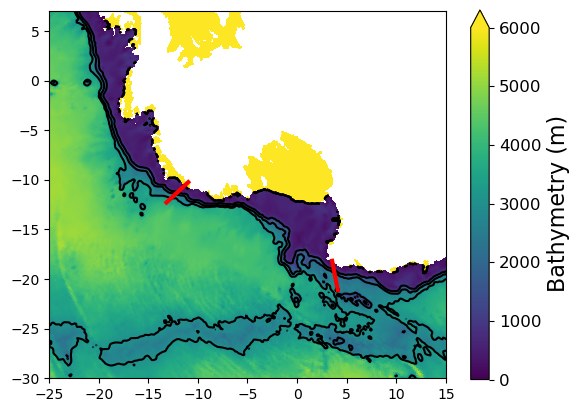

In [12]:
# Plotting of sections on map

# cmap_h = cm.deep
# cmap_h.set_under('w')
fig = figure()
fig.add_subplot(1, 1, 1, aspect='equal')
pcolor(x, y, h, vmin=0, vmax=6000) # , cmap=cmap_h
cbar = colorbar(extend='max')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Bathymetry (m)', fontsize=16)
contour(x, y, h, levels=[1000, 2000, 3000], colors='k')
# Plot sections
for i in range(size(x_sec,1)):
    number = i+1
    plot(x_sec[:,i], y_sec[:,i], color='r', linewidth=3)

# Grid
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7
xlim(xlim_min, xlim_max)
ylim(ylim_min, ylim_max);
# xlim([-30,30])
# ylim([-30,30])

# xlim(0, 5)
# ylim(-21,-15)

### Extract data along cross-slope sections

Run function at the end of the script for continuing with this section.

Ross Sea

In [12]:
i = 0

In [15]:
# Interpolate 3d variables, z, lat
temp_RS_cntr, z_RS, lat_RS  = interp_lon(temp_cntr, z_3d, lat_2d, lon_2d, lon_start[i])
temp_RS_pert, z_RS, lat_RS  = interp_lon(temp_pert, z_3d, lat_2d, lon_2d, lon_start[i])

salt_RS_cntr, z_RS, lat_RS  = interp_lon(salt_cntr, z_3d, lat_2d, lon_2d, lon_start[i])
salt_RS_pert, z_RS, lat_RS  = interp_lon(salt_pert, z_3d, lat_2d, lon_2d, lon_start[i])

In [16]:
speed_roms_RS_cntr, lat_RS_2d = interp_lon_2d(speed_roms_cntr, lat_2d, lon_2d, lon_start[i])
speed_roms_RS_pert, lat_RS_2d = interp_lon_2d(speed_roms_pert, lat_2d, lon_2d, lon_start[i])

In [17]:
speed_cice_RS_cntr, lat_RS_2d = interp_lon_2d(speed_cice_cntr[:-13,:-1], lat_2d, lon_2d, lon_start[i])
speed_cice_RS_pert, lat_RS_2d = interp_lon_2d(speed_cice_pert[:-13,:-1], lat_2d, lon_2d, lon_start[i])

Amundsen Sea

In [18]:
i = 1

In [19]:
# Interpolate 3d variables, z, lat
temp_AS_cntr, z_AS, lat_AS  = interp_lon(temp_cntr, z_3d, lat_2d, lon_2d, lon_start[i])
temp_AS_pert, z_AS, lat_AS  = interp_lon(temp_pert, z_3d, lat_2d, lon_2d, lon_start[i])

salt_AS_cntr, z_AS, lat_AS  = interp_lon(salt_cntr, z_3d, lat_2d, lon_2d, lon_start[i])
salt_AS_pert, z_AS, lat_AS  = interp_lon(salt_pert, z_3d, lat_2d, lon_2d, lon_start[i])

In [20]:
speed_roms_AS_cntr, lat_AS_2d = interp_lon_2d(speed_roms_cntr, lat_2d, lon_2d, lon_start[i])
speed_roms_AS_pert, lat_AS_2d = interp_lon_2d(speed_roms_pert, lat_2d, lon_2d, lon_start[i])

In [21]:
speed_cice_AS_cntr, lat_AS_2d = interp_lon_2d(speed_cice_cntr[:-13,:-1], lat_2d, lon_2d, lon_start[i])
speed_cice_AS_pert, lat_AS_2d = interp_lon_2d(speed_cice_pert[:-13,:-1], lat_2d, lon_2d, lon_start[i])

In [ ]:
# lat_AS_2d_cice = lat_AS_2d_cice[]

Calculate density

In [22]:
# pres_AS = -gsw.p_from_z(z_AS,lat_AS)
# pres_RS = -gsw.p_from_z(z_RS,lat_RS)

rho_AS_cntr  = gsw.sigma0(salt_AS_cntr, temp_AS_cntr)
rho_AS_pert  = gsw.sigma0(salt_AS_pert, temp_AS_pert)

rho_RS_cntr  = gsw.sigma0(salt_RS_cntr, temp_RS_cntr)
rho_RS_pert  = gsw.sigma0(salt_RS_pert, temp_RS_pert)

### Plotting

In [23]:
# Figure saving info
ft_size = 14
my_dpi  = 150
fig_path = '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/figures/'

/jobfs/99440139.gadi-pbs/ipykernel_1459996/2230531020.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  sc = pcolor(lat_AS, z_AS, salt_AS_pert-salt_AS_cntr, vmin=-0.4, vmax=0.4, cmap=cm.balance)
/jobfs/99440139.gadi-pbs/ipykernel_1459996/2230531020.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(lat_RS, z_RS, salt_RS_pert-salt_RS_cntr, vmin=-0.4, vmax=0.4, cmap=cm.balance)
/jobfs/99440139.gadi-pbs/ipykernel_1459996/2230531020.py:37: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now se

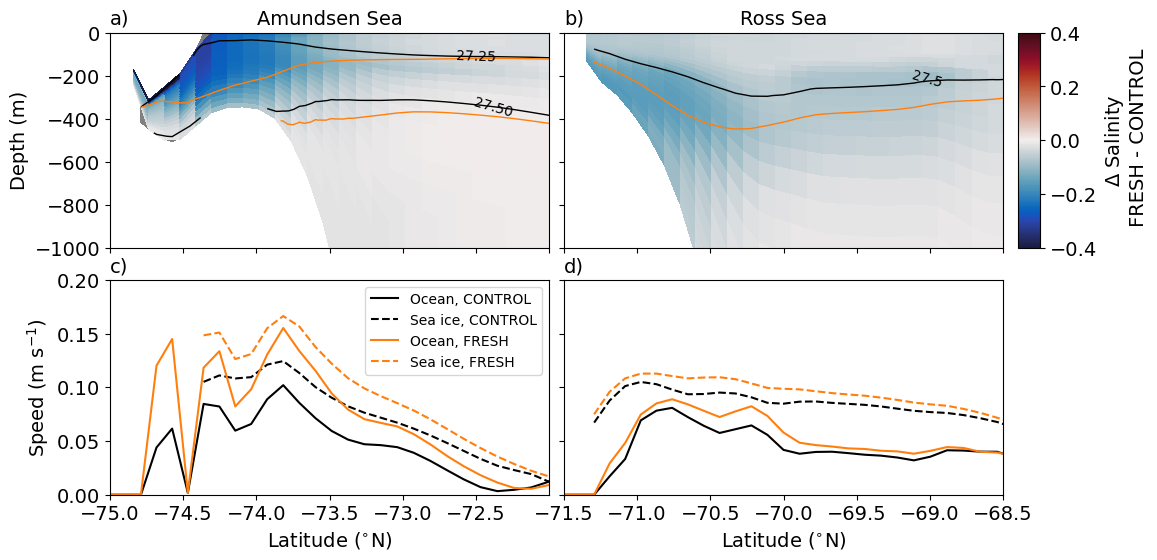

In [32]:
fig = figure(figsize=(12,6))

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.15)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[1,1,0.05], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[1,1,0.05], \
        subplot_spec=gs[1], wspace=0.05)

ax = fig.add_subplot(gs0[0,0])
title('Amundsen Sea', fontsize=ft_size)
title('a)', loc='left', fontsize=ft_size)
contourf(lat_AS, z_AS, salt_AS_pert/salt_AS_pert, colors='0.5')
sc = pcolor(lat_AS, z_AS, salt_AS_pert-salt_AS_cntr, vmin=-0.4, vmax=0.4, cmap=cm.balance)
CS = contour(lat_AS, z_AS, rho_AS_cntr, levels=[27.25, 27.5], colors='k', linewidths=1)
clabel(CS, inline=False, manual=[(-72.5,-100), (-72.5,-400)])
contour(lat_AS, z_AS, rho_AS_pert, levels=[27.25, 27.5], colors='C1', linewidths=1)
xlim(lat_start[1], lat_end[1])
ylim(-1000, 0)
setp(ax.get_xticklabels(), visible=False)
ylabel('Depth (m)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size)

ax = fig.add_subplot(gs0[0,1])
title('Ross Sea', fontsize=ft_size)
title('b)', loc='left', fontsize=ft_size)
pcolor(lat_RS, z_RS, salt_RS_pert-salt_RS_cntr, vmin=-0.4, vmax=0.4, cmap=cm.balance)
CS = contour(lat_RS, z_RS, rho_RS_cntr, levels=[27.5], colors='k', linewidths=1)
clabel(CS, inline=False, manual=[(-69,-200)])
CS = contour(lat_RS, z_RS, rho_RS_pert, levels=[27.5], colors='C1', linewidths=1)
# clabel(CS, inline=False, manual=[(-69,-400)])
xlim(lat_start[0], lat_end[0])
ylim(-1000, 0)
setp(ax.get_xticklabels(), visible=False)
setp(ax.get_yticklabels(), visible=False)

cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.4, 0.41, 0.2))
cbar.ax.tick_params(labelsize=ft_size)
cbar.set_label('$\Delta$ Salinity \n FRESH - CONTROL', fontsize=ft_size)

ax = fig.add_subplot(gs1[0,0])
title('c)', loc='left', fontsize=ft_size)
# plot(lat_AS_2d, speed_cice_AS_cntr-speed_roms_AS_cntr, color='k')
plot(lat_AS_2d, speed_roms_AS_cntr, color='k', label='Ocean, CONTROL')
plot(lat_AS_2d[1:], speed_cice_AS_cntr[:-1], color='k', linestyle='--', label='Sea ice, CONTROL')
plot(lat_AS_2d, speed_roms_AS_pert, color='C1', label='Ocean, FRESH')
plot(lat_AS_2d[1:], speed_cice_AS_pert[:-1], color='C1', linestyle='--', label='Sea ice, FRESH')
legend()
ylabel('Speed (m s$^{-1}$)', fontsize=ft_size)
ylim(0, 0.2)
xlim(lat_start[1], lat_end[1])
xlabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size)
ax.set_xticks(arange(-75, -72, 0.5))

ax = fig.add_subplot(gs1[0,1])
title('d)', loc='left', fontsize=ft_size)
# plot(lat_RS_2d, speed_cice_RS_cntr-speed_roms_RS_cntr, color='k')
plot(lat_RS_2d, speed_roms_RS_cntr, color='k')
plot(lat_RS_2d[1:], speed_cice_RS_cntr[:-1], color='k', linestyle='--')
plot(lat_RS_2d, speed_roms_RS_pert, color='C1')
plot(lat_RS_2d[1:], speed_cice_RS_pert[:-1], color='C1', linestyle='--')
# axhline(0, linewidth=0.5, color='k')
ylim(0, 0.2)
xlim(lat_start[0], lat_end[0])
xlabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size)
setp(ax.get_yticklabels(), visible=False)

# Finished
plot_flag = 1
if plot_flag == 1:
    fig_name = 'FigureS5.png'
    savefig(fig_path + fig_name, dpi=my_dpi, bbox_inches='tight', facecolor='white');

(-75.0, -72.0)

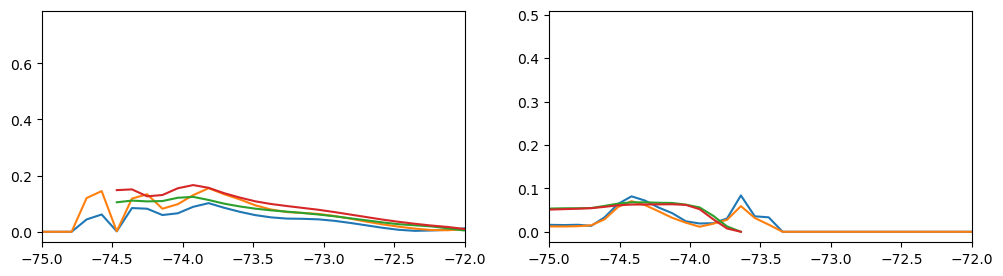

In [44]:
fig = figure(figsize=(12,3))

subplot(121)
plot(lat_AS_2d, speed_roms_AS_cntr)
plot(lat_AS_2d, speed_roms_AS_pert)
plot(lat_AS_2d, speed_cice_AS_cntr)
plot(lat_AS_2d, speed_cice_AS_pert)
xlim(lat_start[1], lat_end[1])

subplot(122)
plot(lat_RS_2d, speed_roms_RS_cntr)
plot(lat_RS_2d, speed_roms_RS_pert)
plot(lat_RS_2d, speed_cice_RS_cntr)
plot(lat_RS_2d, speed_cice_RS_pert)
xlim(lat_start[1], lat_end[1])

/jobfs/99157047.gadi-pbs/ipykernel_3612343/2898884545.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(lat_AS, z_AS, rho_AS_cntr, vmin=27.25, vmax=27.75, cmap=cm.dense)
/jobfs/99157047.gadi-pbs/ipykernel_3612343/2898884545.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(lat_RS, z_RS, rho_RS_cntr, vmin=27.25, vmax=27.75, cmap=cm.dense)
/jobfs/99157047.gadi-pbs/ipykernel_3612343/2898884545.py:18: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in

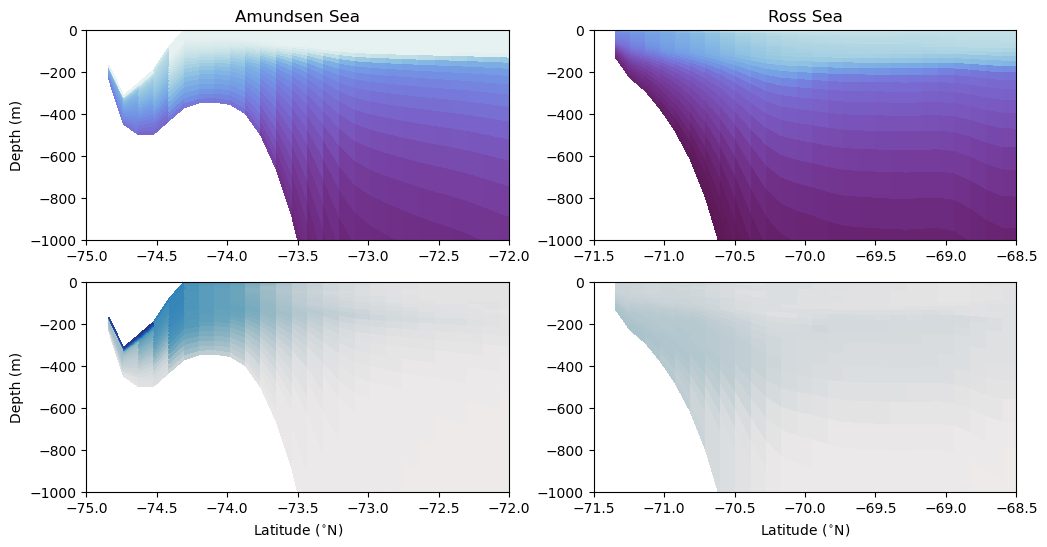

In [189]:
fig = figure(figsize=(12,6))

subplot(221)
title('Amundsen Sea')
pcolor(lat_AS, z_AS, rho_AS_cntr, vmin=27.25, vmax=27.75, cmap=cm.dense)
# colorbar()
xlim(lat_start[1], lat_end[1])
ylim(-1000, 0)
ylabel('Depth (m)')

subplot(222)
title('Ross Sea')
pcolor(lat_RS, z_RS, rho_RS_cntr, vmin=27.25, vmax=27.75, cmap=cm.dense)
xlim(lat_start[0], lat_end[0])
ylim(-1000, 0)

subplot(223)
pcolor(lat_AS, z_AS, rho_AS_pert-rho_AS_cntr, vmin=-0.5, vmax=0.5, cmap=cm.balance)
xlim(lat_start[1], lat_end[1])
ylim(-1000, 0)
xlabel('Latitude ($^{\circ}$N)')
ylabel('Depth (m)')

subplot(224)
pcolor(lat_RS, z_RS, rho_RS_pert-rho_RS_cntr, vmin=-0.5, vmax=0.5, cmap=cm.balance)
xlim(lat_start[0], lat_end[0])
ylim(-1000, 0)
xlabel('Latitude ($^{\circ}$N)');

/jobfs/99157047.gadi-pbs/ipykernel_3612343/3477985211.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(lat_AS, z_AS, temp_AS_cntr, vmin=-2, vmax=2, cmap=cm.thermal)
/jobfs/99157047.gadi-pbs/ipykernel_3612343/3477985211.py:12: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcolor(lat_RS, z_RS, temp_RS_cntr, vmin=-2, vmax=2, cmap=cm.thermal)
/jobfs/99157047.gadi-pbs/ipykernel_3612343/3477985211.py:17: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which c

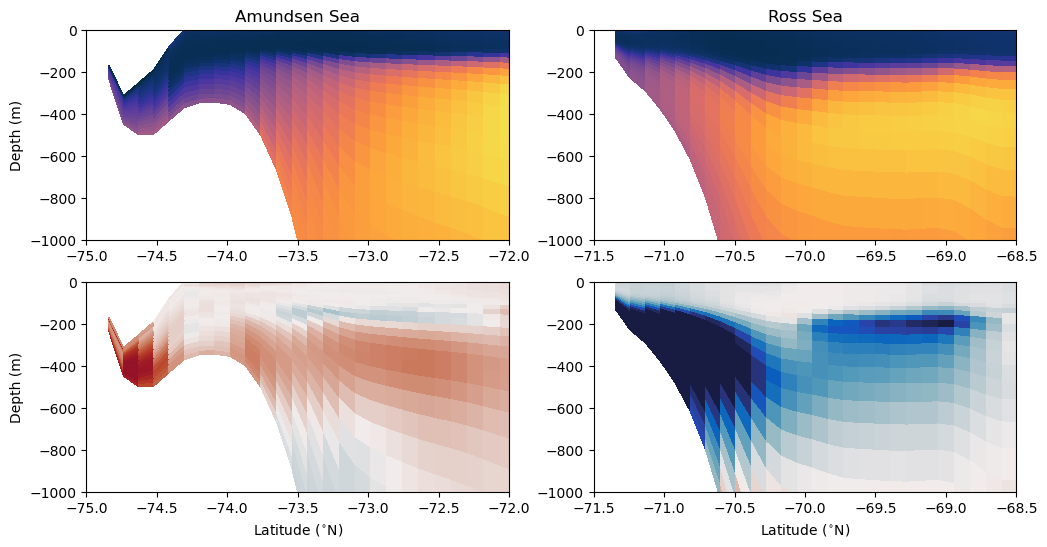

In [173]:
fig = figure(figsize=(12,6))

subplot(221)
title('Amundsen Sea')
pcolor(lat_AS, z_AS, temp_AS_cntr, vmin=-2, vmax=2, cmap=cm.thermal)
xlim(lat_start[1], lat_end[1])
ylim(-1000, 0)
ylabel('Depth (m)')

subplot(222)
title('Ross Sea')
pcolor(lat_RS, z_RS, temp_RS_cntr, vmin=-2, vmax=2, cmap=cm.thermal)
xlim(lat_start[0], lat_end[0])
ylim(-1000, 0)

subplot(223)
pcolor(lat_AS, z_AS, temp_AS_pert-temp_AS_cntr, vmin=-0.5, vmax=0.5, cmap=cm.balance)
xlim(lat_start[1], lat_end[1])
ylim(-1000, 0)
xlabel('Latitude ($^{\circ}$N)')
ylabel('Depth (m)')

subplot(224)
pcolor(lat_RS, z_RS, temp_RS_pert-temp_RS_cntr, vmin=-0.5, vmax=0.5, cmap=cm.balance)
xlim(lat_start[0], lat_end[0])
ylim(-1000, 0)
xlabel('Latitude ($^{\circ}$N)');

---

Functions used above

In [14]:
# Linearly interpolate data, z, and latitude to the specified section between two coordinates: script 1 (loop over lat)
# Input:
# data_3d = array of data, dimension depth x lat x lon
# z_3d = array of depth values (negative, in metres), dimension depth x lat x lon
# lat_2d  = array of latitude values, dimension lat x lon
# lon_2d  = array of longitude values, dimension lat x lon (between -180 and 180)
# lon_min = longitude of start point
# lon_max = longitude of end point
# lat_min = latitude of start point
# lat_max = latitude of end point
# Output:
# data = array of data interpolated to section, dimension depth x lat
# z = array of depth values interpolated to section, dimension depth x lat
# lat = array of latitude values interpolated to section, dimension depth x lat
def interp_sec (data_3d, z_3d, lat_2d, lon_2d, lon_min, lon_max, lat_min, lat_max):

    # Save dimensions
    num_depth = size(data_3d, 0)
    num_lat = size(data_3d, 1)
    num_lon = size(data_3d, 2)
    # Set up output arrays
    data = ma.empty([num_depth, num_lat]) # ma.empty([num_depth, num_lat])
    z = ma.empty([num_depth, num_lat])
    lat = ma.empty([num_depth, num_lat])
    # Calculate linear regression to get lon0 values for each latitude (to get lon0)
    reg_val = polyfit([lat_min,lat_max], [lon_min,lon_max], 1)

    # Loop over latitudes; can't find a cleaner way to do this
    for j in range(num_lat):
        # Calculate lon0 for this slice
        lon0 = lat_2d[j,0]*reg_val[0]+reg_val[1] 
        # Extract the longitude values of this slice
        lon_tmp = lon_2d[j,:]
        # Get indices and coefficients for interpolation
        # If lon0 would be east of 360, fill with fill value (1e9)
        if lon0 < 360:
            ie, iw, coeffe, coeffw = interp_lon_helper(lon_tmp, lon0)        
            data[:,j] = coeffe*data_3d[:,j,ie] + coeffw*data_3d[:,j,iw]
            z[:,j] = coeffe*z_3d[:,j,ie] + coeffw*z_3d[:,j,iw]
            lat[:,j] = coeffe*lat_2d[j,ie] + coeffw*lat_2d[j,iw]
        else:
            data[:,j] = 1e9
            z[:,j] = 1e9
            lat[:,j] = 1e9

    return data, z, lat





# Linearly interpolate data, z, and latitude to the specified longitude.
# Input:
# data_3d = array of data, dimension depth x lat x lon
# z_3d = array of depth values (negative, in metres), dimension depth x lat x lon
# lat_2d = array of latitudevalues, dimension lat x lon
# lon_2d = array of longitude values, dimension lat x lon (between -180 and 180)
# lon0 = longitude to interpolate to (between -180 and 180)
# Output:
# data = array of data interpolated to lon0, dimension depth x lat
# z = array of depth values interpolated to lon0, dimension depth x lat
# lat = array of latitude values interpolated to lon0, dimension depth x lat
def interp_lon (data_3d, z_3d, lat_2d, lon_2d, lon0):

    # Save dimensions
    num_depth = size(data_3d, 0)
    num_lat = size(data_3d, 1)
    num_lon = size(data_3d, 2)
    # Set up output arrays
    data = ma.empty([num_depth, num_lat]) # ma.empty([num_depth, num_lat])
    z = ma.empty([num_depth, num_lat])
    lat = ma.empty([num_depth, num_lat])

    # Loop over latitudes; can't find a cleaner way to do this
    for j in range(num_lat):
        # Extract the longitude values of this slice
        lon_tmp = lon_2d[j,:]
        # Get indices and coefficients for interpolation
        ie, iw, coeffe, coeffw = interp_lon_helper(lon_tmp, lon0)        
        data[:,j] = coeffe*data_3d[:,j,ie] + coeffw*data_3d[:,j,iw]
        z[:,j] = coeffe*z_3d[:,j,ie] + coeffw*z_3d[:,j,iw]
        lat[:,j] = coeffe*lat_2d[j,ie] + coeffw*lat_2d[j,iw]

    return data, z, lat


# Linearly interpolate data, z, and latitude to the specified longitude.
# Input:
# data_3d = array of data, dimension depth x lat x lon
# z_3d = array of depth values (negative, in metres), dimension depth x lat x lon
# lat_2d = array of latitudevalues, dimension lat x lon
# lon_2d = array of longitude values, dimension lat x lon (between -180 and 180)
# lon0 = longitude to interpolate to (between -180 and 180)
# Output:
# data = array of data interpolated to lon0, dimension depth x lat
# z = array of depth values interpolated to lon0, dimension depth x lat
# lat = array of latitude values interpolated to lon0, dimension depth x lat
def interp_lon_2d (data_2d, lat_2d, lon_2d, lon0):

    # Save dimensions
    num_lat = size(data_2d, 0)
    num_lon = size(data_2d, 1)
    # Set up output arrays
    data = ma.empty([num_lat])
    lat = ma.empty([num_lat])

    # Loop over latitudes; can't find a cleaner way to do this
    for j in range(num_lat):
        # Extract the longitude values of this slice
        lon_tmp = lon_2d[j,:]
        # Get indices and coefficients for interpolation
        ie, iw, coeffe, coeffw = interp_lon_helper(lon_tmp, lon0)        
        data[j] = coeffe*data_2d[j,ie] + coeffw*data_2d[j,iw]
        lat[j]  = coeffe*lat_2d[j,ie] + coeffw*lat_2d[j,iw]

    return data, lat



# Calculate indices and coefficients for linear interpolation of longitude.
# This takes care of all the mod 360 nonsense.
# Input:
# lon = 1D array of longitude values (straight out of ROMS i.e. between slightly < 0 and slightly > 360)
# lon0 = longitude to interpolate to (between 0 and 360)
# Output:
# ie, iw, coeffe, coeffw = integers (ie and iw) and coefficients (coeffe and coeffw) such that
#                          coeffe*lon[ie] + coeffw*lon[iw] = lon0, which will also hold for any
#                          variable on this longitude grid. ie is the index of the nearest point
#                          to the east of lon0; iw the nearest point to the west.
def interp_lon_helper (lon, lon0):

    if lon0 < amin(lon) or lon0 > amax(lon):
        # Special case: lon0 on periodic boundary
        # Be careful with mod 360 here

        # Find the periodic boundary
        dlon = lon[1:] - lon[0:-1]
        bdry = argmax(abs(dlon))
        if dlon[bdry] < -300:
            # Jumps from almost 360 to just over 0
            iw = bdry
            ie = bdry + 1
        else:
            # Periodic boundary lines up with the array boundary
            iw = size(lon) - 1
            ie = 0
        # Calculate difference between lon0 and lon[iw], mod 360 if necessary
        dlon_num = lon0 - lon[iw]
        if dlon_num < -300:
            dlon_num += 360
        # Calculate difference between lon[ie] and lon[iw], mod 360
        dlon_den = lon[ie] - lon[iw] + 360

    else:
        # General case

        # Add or subtract 360 from longitude values which wrap around
        # so that longitude increases monotonically from west to east
        i = arange(1, size(lon)+1)
        index1 = nonzero((i > 1200)*(lon < 100))
        lon[index1] = lon[index1] + 360
        index2 = nonzero((i < 200)*(lon > 300))
        lon[index2] = lon[index2] - 360

        # Take mod 360 of lon0 if necessary
        if all(lon < lon0):
            lon0 -= 360
        if all(lon > lon0):
            lon0 += 360
        
        # Find the first index eastward of lon0
        ie = nonzero(lon > lon0)[0][0]
        # The index before it will be the last index westward of lon0
        iw = ie - 1

        dlon_num = lon0 - lon[iw]
        dlon_den = lon[ie] - lon[iw]

    if dlon_num > 5 or dlon_den > 5:
        print('interp_lon_helper: Problem at periodic boundary')
        return
    coeff1 = dlon_num/dlon_den
    coeff2 = 1 - coeff1

    return ie, iw, coeff1, coeff2